<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naive-Bayes" data-toc-modified-id="Naive-Bayes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naive Bayes</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Elastic-Net" data-toc-modified-id="Elastic-Net-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Elastic Net</a></span><ul class="toc-item"><li><span><a href="#Experiment-pipeline" data-toc-modified-id="Experiment-pipeline-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Experiment pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>RandomForest</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Light-Gradient-Boosting" data-toc-modified-id="Light-Gradient-Boosting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Light Gradient Boosting</a></span><ul class="toc-item"><li><span><a href="#Experiment-Pipeline" data-toc-modified-id="Experiment-Pipeline-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Experiment Pipeline</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Summary</a></span></li></ul></li></ul></div>

In this experiment we will build a simple pipeline using thew training set along with the handfull of binary features engineered during the project initiation stage to train classifiers using:

- Naive Bayes
- Elastic Net
- RandomForest
- Light Gradient Boosting

**Main difference from experiment 1**: we will add an oversampling step to randomly oversample minority classes to make the training set balanced.

We will monitor `matthews_corrcoef` when training the classifiers and then document `classification_report` for both training and validation sets.

In [50]:
e_num = '2'

## Naive Bayes

### Experiment Pipeline

In [56]:
from sklearn.naive_bayes import BernoulliNB # Note that all features we will use here are binary
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt

start_time = datetime.now()

np.random.seed(1235)

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')

# MCC scorer for GridSearchCV
mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    # Only retain features
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",BernoulliNB())
])

param_grid = {
                "clf__alpha":np.linspace(1,1000,100),
                "clf__fit_prior":[True,False],
                "add_poly_int__degree":[1,2,3],
                "feature_selection__k":['all',10,20,30]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.13686542 0.13254599        nan ... 0.10390593 0.11187606 0.13254599]
  category=UserWarning


NameError: name 'end_time' is not defined

### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 1, 'clf__alpha': 1.0, 'clf__fit_prior': True, 'feature_selection__k': 'all'}

Best cross-validated performance estimate (MCC): 0.1369

MCC estimate (training set):  0.1369

Balanced accuracy (training set): 0.4041

Classification report (training set):

              precision    recall  f1-score   support

           0       0.55      0.24      0.33     14307
           1       0.35      0.80      0.49     14307
           2       0.57      0.17      0.26     14307

    accuracy                           0.40     42921
   macro avg       0.49      0.40      0.36     42921
weighted avg       0.49      0.40      0.36     42921


Confusion matrix (training set):

[[ 3444 10212   651]
 [ 1624 11474  1209]
 [ 1210 10672  2425]]


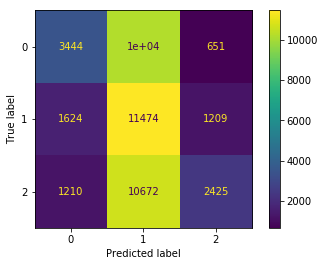

In [58]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/naive_bayes.pkl","wb") as f:
    pkl.dump(clf_search,f)

## Elastic Net

### Experiment pipeline

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')

mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",LogisticRegression(penalty = "elasticnet", solver='saga'))
])

param_grid = {
                "clf__C":np.linspace(0,1,10).tolist() + np.linspace(1,100,10).tolist(),
                "clf__l1_ratio":np.linspace(0,1,10),
                "add_poly_int__degree":[2],
                "feature_selection__k":['all',10,20,30]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.1439304  0.11740586
 0.14076997 0.1439304  0.1439304  0.11740586 0.14076997 0.1439304
 0.1439304  0.11740586 0.14076997 0.1439304  0.1439304  0.11740586
 0.14076997 0.1439304  0.1439304  0.11740586 0.14076997 0.1439304
 0.1439304  0.11740586 0.14076997 0.1439304  0.1439304  0.11740586
 0.14076997 0.1439304  0.1439304  0.11740586 0.14076997 0.1439304
 0.1439304  0.11740586 0.14076997 0.1439304  0.1439304  0

Time elapsed: 26.6167 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 2, 'clf__C': 0.1111111111111111, 'clf__l1_ratio': 0.0, 'feature_selection__k': 'all'}

Best cross-validated performance estimate (MCC): 0.1439

MCC estimate (training set):  0.144

Balanced accuracy (training set): 0.4081

Classification report (training set):

              precision    recall  f1-score   support

           0       0.56      0.25      0.34     14307
           1       0.36      0.80      0.49     14307
           2       0.58      0.18      0.27     14307

    accuracy                           0.41     42921
   macro avg       0.50      0.41      0.37     42921
weighted avg       0.50      0.41      0.37     42921


Confusion matrix (training set):

[[ 3533 10154   620]
 [ 1624 11474  1209]
 [ 1197 10603  2507]]


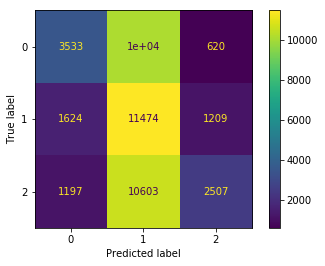

In [60]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/elastic_net.pkl","wb") as f:
    pkl.dump(clf_search,f)

## RandomForest

### Experiment Pipeline

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')

mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",RandomForestClassifier(n_estimators = 300,random_state = 123))
])

param_grid = {
                "clf__min_samples_leaf":[100,250,500,750,1000],
                "clf__class_weight":['balanced','balanced_subsample'],
                "add_poly_int__degree":[1,2,3],
                "feature_selection__k":['all',10,20,30,50]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 150 candidates, totalling 750 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.14473502 0.14153275        nan        nan        nan 0.13280406
 0.12942917        nan        nan        nan 0.12330033 0.12330033
        nan        nan        nan 0.11037152 0.11037152        nan
        nan        nan 0.11037152 0.11037152        nan        nan
        nan 0.14473502 0.14153275        nan        nan        nan
 0.13280406 0.12942917        nan        nan        nan 0.12330033
 0.12330033        nan        nan        nan 0.11037152 0.11037152
        nan        nan        nan 0.11037152 0.11037152        nan
        nan        nan 0.14473502 0.11767236 0.14153275 0.14473502
 0.14473502 0.13280406 0.11084964 0.12942917 0.13280406 0.13280406
 0.12330033 0.11284878 0.12330033 0.12330033 0.12330033 0.11037152
 0.11037152 0.11037152 0.11037152 0.11037152 0.11037152 0.11037152
 0.11037152 0.11037152 0.11037152 0.14473502 0.1176723

Time elapsed: 6.45 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 1, 'clf__class_weight': 'balanced', 'clf__min_samples_leaf': 100, 'feature_selection__k': 'all'}

Best cross-validated performance estimate (MCC): 0.1447

MCC estimate (training set):  0.1448

Balanced accuracy (training set): 0.4085

Classification report (training set):

              precision    recall  f1-score   support

           0       0.56      0.25      0.35     14307
           1       0.36      0.80      0.49     14307
           2       0.57      0.17      0.27     14307

    accuracy                           0.41     42921
   macro avg       0.50      0.41      0.37     42921
weighted avg       0.50      0.41      0.37     42921


Confusion matrix (training set):

[[ 3582 10080   645]
 [ 1624 11474  1209]
 [ 1166 10664  2477]]


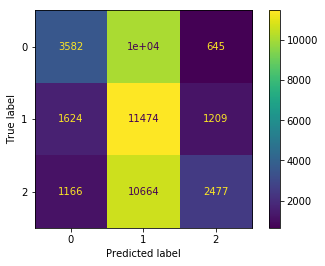

In [62]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/randomForest.pkl","wb") as f:
    pkl.dump(clf_search,f)

## Light Gradient Boosting
### Experiment Pipeline

In [63]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef,make_scorer, balanced_accuracy_score
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import pickle as pkl
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

start_time = datetime.now()

# load the configuration file
with open("config.json",'rb') as f:
    config = json.load(f)
feature_store_dir = config['feature_store_dir']    

# Load data sets, prepare x_train and y_train
analytical_data = pd.read_csv(feature_store_dir + 'analytical_data.csv')
train_knumber = pd.read_csv(feature_store_dir + 'train_KNUMBER.csv')
dummy_features = pd.read_csv(feature_store_dir + "features_dummy.csv")

x_train = pd.merge(train_knumber[['KNUMBER','DATASET']],
    analytical_data[['KNUMBER','COMPLEXITY']], how='left', on = "KNUMBER")
x_train = pd.merge(x_train,dummy_features, how = 'left', on='KNUMBER')

mcc = make_scorer(matthews_corrcoef)

def oversample(train_set):
    # Determine the oversampling needed 
    class_freq = train_set.loc[:,"COMPLEXITY"].value_counts()
    class_max = train_set.loc[:,"COMPLEXITY"].value_counts().max()
    class_freq = class_freq - class_max
    minority_classes = class_freq.index[class_freq < 0].tolist()
    # Implement random oversampling
    for mc in minority_classes:
        # number of oversamples needed
        n_samples = abs(class_freq[mc])
        # get respective class samples from the training set
        mc_data = train_set[train_set.COMPLEXITY == mc].copy()
        # random sample from mc_data to give desired n_samples
        mc_random_indx = np.random.choice(range(mc_data.shape[0]),replace=True,size=n_samples)
        # Sample this data and concatenate into train_set
        train_set =  pd.concat([train_set,mc_data.iloc[mc_random_indx,:]])
    # Shuffle the training set
    train_set = shuffle(train_set,random_state=123)
    return train_set

x_train = oversample(x_train)
# Encode target labels:
# 0 = L, 1 = M, 2 = H
y_train = x_train[['KNUMBER','COMPLEXITY']].copy()
y_train.loc[:,'value'] = 0
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'M'] = 1
y_train.loc[:,'value'][y_train.loc[:,'COMPLEXITY'] == 'H'] = 2
y_train = y_train.loc[:,'value'].values

def prepare_input(train_set):
    train_set = train_set.drop(['KNUMBER','DATASET', 'COMPLEXITY'],axis = 1)
    return train_set

clf_pipeline = Pipeline(steps=[
    ("prepare_input",FunctionTransformer(prepare_input)),
    ("add_poly_int", PolynomialFeatures()),
    ("feature_selection",SelectKBest(chi2)),
    ("clf",LGBMClassifier(n_estimators = 300,
                          objective = 'multiclass',
                          random_state = 123))
])

param_grid = {
                "clf__min_child_samples":[100,250,500,750,1000],
                "clf__class_weight":['balanced',None],
                "clf__num_leaves":[15,31,60],
                "add_poly_int__degree":[1,2,3],
                "feature_selection__k":['all',10,20,30,50]
             }

clf_search = GridSearchCV(clf_pipeline,
                          param_grid = param_grid,
                          scoring = mcc,
                          cv = 5,
                          n_jobs=7,
                          verbose=7
                          )
clf_search.fit(X = x_train,y = y_train)

end_time = datetime.now()

print("Time elapsed: "+ str(round((end_time - start_time).seconds/60,4)) + " minutes.")

C:\Users\OZAN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\OZAN\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Fitting 5 folds for each of 450 candidates, totalling 2250 fits


C:\Users\OZAN\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.14530923 0.14122204        nan        nan        nan 0.14530923
 0.14122204        nan        nan        nan 0.14530923 0.14122204
        nan        nan        nan 0.14009256 0.1358915         nan
        nan        nan 0.14009256 0.1358915         nan        nan
        nan 0.14009256 0.1358915         nan        nan        nan
 0.12526157 0.12337391        nan        nan        nan 0.12526157
 0.12337391        nan        nan        nan 0.12526157 0.12337391
        nan        nan        nan 0.12705728 0.12705728        nan
        nan        nan 0.12705728 0.12705728        nan        nan
        nan 0.12705728 0.12705728        nan        nan        nan
 0.11363573 0.11363573        nan        nan        nan 0.11363573
 0.11363573        nan        nan        nan 0.11363573 0.11363573
        nan        nan        nan 0.14530923 0.1412220

Time elapsed: 10.8833 minutes.


### Summary

Pipeline hyperparameters that performed the best:
{'add_poly_int__degree': 1, 'clf__class_weight': 'balanced', 'clf__min_child_samples': 100, 'clf__num_leaves': 15, 'feature_selection__k': 'all'}

Best cross-validated performance estimate (MCC): 0.1453

MCC estimate (training set):  0.1453

Balanced accuracy (training set): 0.4086

Classification report (training set):

              precision    recall  f1-score   support

           0       0.57      0.25      0.35     14307
           1       0.36      0.80      0.49     14307
           2       0.58      0.17      0.27     14307

    accuracy                           0.41     42921
   macro avg       0.50      0.41      0.37     42921
weighted avg       0.50      0.41      0.37     42921


Confusion matrix (training set):

[[ 3581 10104   622]
 [ 1624 11474  1209]
 [ 1126 10697  2484]]


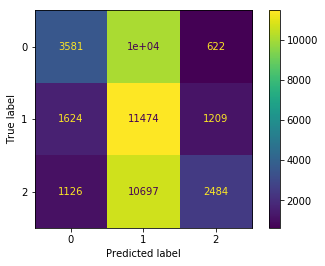

In [64]:
print('Pipeline hyperparameters that performed the best:')
print(clf_search.best_params_)
print("")
print("Best cross-validated performance estimate (MCC): "+ str(np.round(clf_search.best_score_,4)))
print("")
print("MCC estimate (training set): ", str(np.round(matthews_corrcoef(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print("Balanced accuracy (training set): "+ 
      str(np.round(balanced_accuracy_score(y_true = y_train, 
        y_pred = clf_search.predict(x_train)),4)))
print("")
print('Classification report (training set):')
print("")
print(classification_report(y_true = y_train, y_pred = clf_search.predict(x_train)))
print("")
print("Confusion matrix (training set):")
print("")
print(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di = ConfusionMatrixDisplay(confusion_matrix(y_true = y_train, y_pred = clf_search.predict(x_train)))
di.plot()
plt.show()
# Save the trained GridSearchCV object
with open("./models/experiment_" + e_num + "/lgbm.pkl","wb") as f:
    pkl.dump(clf_search,f)